In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

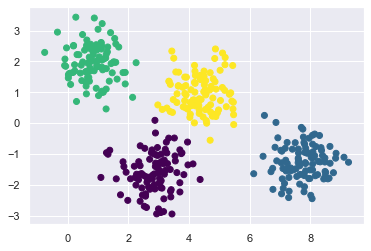

In [4]:
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples = 400, centers = 4,
                      cluster_std = 0.60, random_state = 0)
X = X[:, ::-1] # only for better ploting
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 4, random_state = 0)
labels = kmeans.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c = labels, cmap = 'viridis')

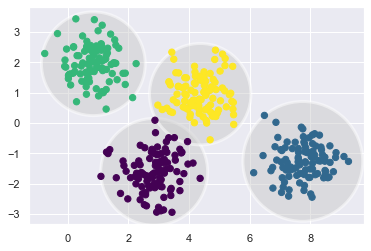

In [6]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters = 4, rseed =4, ax = None):
    labels = kmeans.fit_predict(X)
    
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:,1], c = labels, s = 40, cmap ='viridis', zorder = 2)
    
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max() 
            for i, center in enumerate(centers)]
    
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc = '#CCCCCC', lw=3, alpha = 0.5, zorder = 1))

        
kmeans = KMeans(4, random_state = 0)
plot_kmeans(kmeans, X)

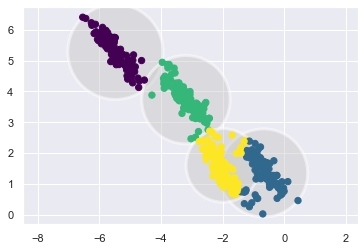

In [9]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2,2))

kmeans = KMeans(n_clusters = 4, random_state = 0)
plot_kmeans(kmeans, X_stretched)

# Generalizing E-M: Gaussian MIxture Models

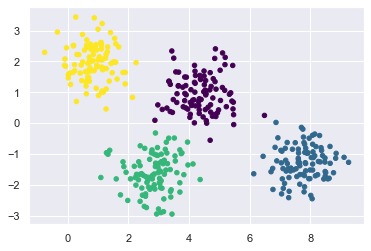

In [13]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components = 4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:,0], X[:, 1], c=labels, cmap = 'viridis', s =20);

In [14]:
prob = gmm.predict_proba(X)
print(prob[:5].round(3))

[[0.531 0.469 0.    0.   ]
 [0.    0.    1.    0.   ]
 [0.    0.    1.    0.   ]
 [1.    0.    0.    0.   ]
 [0.    0.    1.    0.   ]]


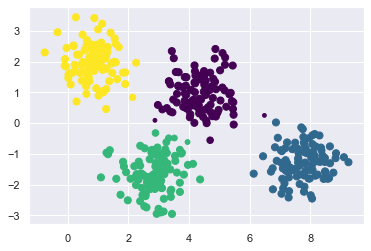

In [15]:
size = 50*prob.max(axis = 1)**2
plt.scatter(X[:,0], X[:, 1], c=labels, cmap = 'viridis', s =size);

In [22]:
from matplotlib.patches import Ellipse
def draw_ellipse(position, covariance, ax = None, **kwargs):
    ax= ax or plt.gca()
    if covariance.shape == (2,2):
        U,s,Vt = np.linalg.svd(covariance)
        angel = np.degrees(np.arctan2(U[1,0], U[0,0]))
        width, height = 2*np.sqrt(s)
    else:
        angel = 0
        width, height = 2*np.sqrt(covariance)
    
    for nsig in range(1,4):
        ax.add_patch(Ellipse(position, nsig*width, nsig*height, angel, **kwargs))
    
def plot_gmm(gmm, X, ax = None, label = True):
    ax = ax or plt.gca()
    labels = gmm.fit_predict(X)
    if label:
        ax.scatter(X[:,0], X[:,1], c=labels, s =40, cmap = 'viridis', zorder = 2)
    else:
        ax.scatter(X[:,0], X[:,1], s = 40, zorder = 2)
    ax.axis('equal')
    
    w_factor = 0.2/gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha = w * w_factor)
    
    
    
    

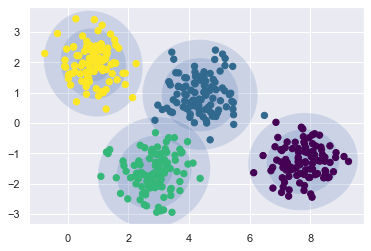

In [23]:
gmm = GaussianMixture(n_components = 4, random_state = 42)
plot_gmm(gmm, X)

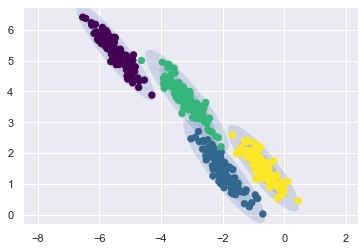

In [25]:
gmm = GaussianMixture(n_components = 4, covariance_type = 'full', random_state = 42)
plot_gmm(gmm, X_stretched)

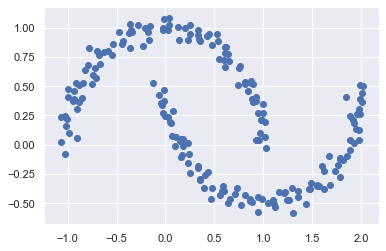

In [28]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(n_samples = 200, noise = 0.05, random_state = 0)
plt.scatter(Xmoon[:,0], Xmoon[:,1]);

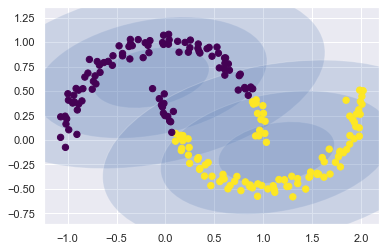

In [30]:
gmm2= GaussianMixture(n_components = 2, random_state = 0, covariance_type = 'full')
plot_gmm(gmm2, Xmoon)

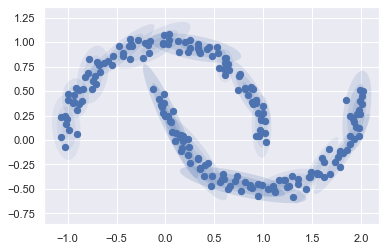

In [32]:
gmm16= GaussianMixture(n_components = 16, random_state = 0, covariance_type = 'full')
plot_gmm(gmm16, Xmoon, label = False)

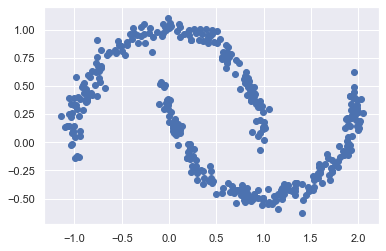

In [46]:
Xnew = gmm16.sample(400) # produce a tuple
#Xnew[0] is the value array, Xnew[1] is the label
plt.scatter(Xnew[0][:,0], Xnew[0][:,1]);

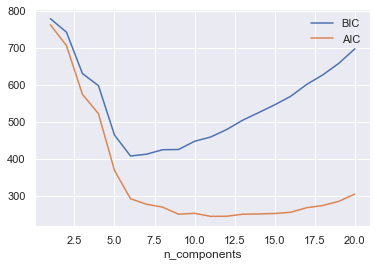

In [48]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(Xmoon)
          for n in n_components]

plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best', frameon = False)
plt.xlabel('n_components');

In [50]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

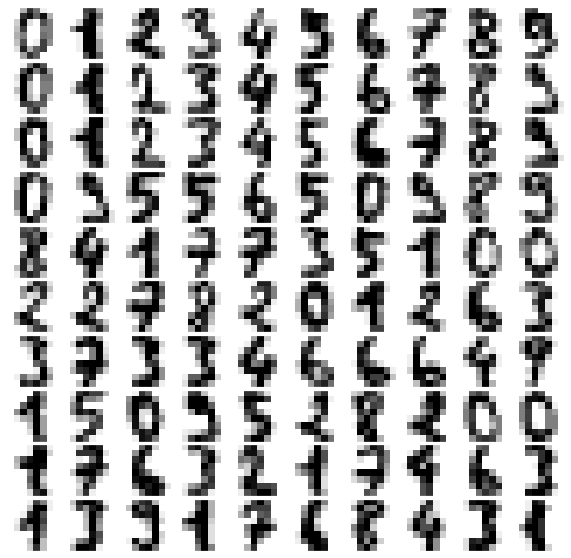

In [54]:
def plot_digits(data):
    fig, axes = plt.subplots(10,10, figsize=(10,10),
                            subplot_kw = dict(xticks = [], yticks =[]),
                            gridspec_kw = dict(hspace=0.05, wspace = 0.05))
    for i, ax in enumerate(axes.flat):
        im = ax.imshow(data[i].reshape(8,8), cmap = 'binary')
        im.set_clim(0,16)
plot_digits(digits.data)

In [55]:
from sklearn.decomposition import PCA
pca = PCA(0.99, whiten = True)
data = pca.fit_transform(digits.data)
data.shape

(1797, 41)

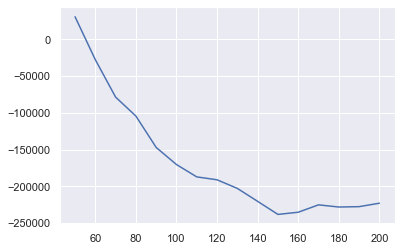

In [58]:
n_components = np.arange(50, 210,10)
models = [GaussianMixture(n, covariance_type = 'full', random_state = 0)
         for n in n_components]
aics = [model.fit(data).aic(data) for model in models]
plt.plot(n_components, aics)

In [61]:
gmm = GaussianMixture(150, covariance_type='full', random_state = 0)
gmm.fit(data)
print(gmm.converged_)

True


In [63]:
data_new = gmm.sample(100)
data_new[0].shape

(100, 41)

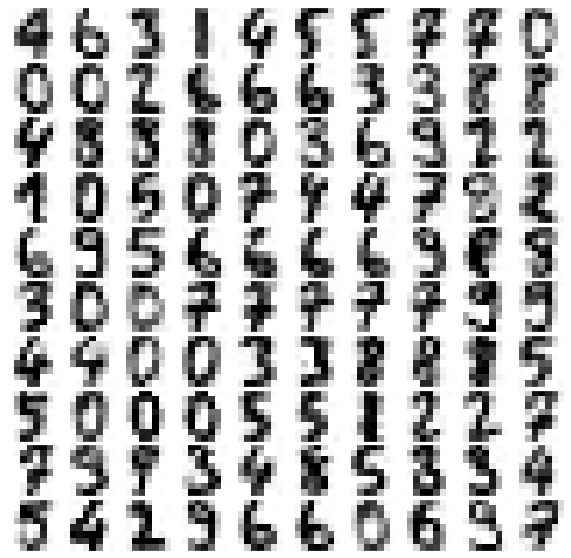

In [65]:
digits_new = pca.inverse_transform(data_new[0])
plot_digits(digits_new)